In [1]:
!pip install -U langgraph langchain_google_genai langchain_community

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.1/158.1 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.32.4
    Uninstalling requests-2.32.4:
      Successfully uninstalled requests-2.32.4
  Attempting uninstall: langgraph
    Found existing installation: langgraph 1.0.7
    Uninstalling langgraph-1.0.7:
      Successfully uninstalled langgraph-1.0.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires re

In [3]:
import getpass
import os
if 'GOOGLE_API_KEY' not in os.environ:
    os.environ['GOOGLE_API_KEY'] = getpass.getpass('Provide your Google API Key: ')

Provide your Google API Key: ··········


In [5]:
import os


os.environ["TAVILY_API_KEY"] = "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"

### Defining Graph State

In [6]:
from typing import Annotated, Literal, TypedDict
from langgraph.graph.message import add_messages

class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

### Defining Our Tools

In [7]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=5)]

/tmp/ipython-input-2664420233.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tools = [TavilySearchResults(max_results=5)]


### Creating Agents

In [8]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder


def create_agent(llm, tools, system_message: str):
    """Create an agent."""
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                "{system_message}",
            ),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    prompt = prompt.partial(system_message=system_message)
    if tools:
      return prompt | llm.bind_tools(tools)
    else:
      return prompt | llm

In [9]:
search_template = """Your job is to search the web for related news that would be relevant to generate the article described by the user.

                  NOTE: Do not write the article. Just search the web for related news if needed and then forward that news to the outliner node.
                  """

outliner_template = """Your job is to take as input a list of articles from the web along with users instruction on what article they want to write and generate an outline
                       for the article.
                    """

writer_template = """Your job is to write an article, do it in this format:

                        TITLE: <title>
                        BODY: <body>

                      NOTE: Do not copy the outline. You need to write the article with the info provided by the outline.

                       ```
                    """

In [16]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model='gemini-2.5-flash')

search_agent = create_agent(llm, tools, search_template)
outliner_agent = create_agent(llm, [], outliner_template)
writer_agent = create_agent(llm, [], writer_template)

### Define Nodes

In [12]:
def agent_node(state, agent, name):
  result = agent.invoke(state)
  return {
      'messages': [result]
  }

In [13]:
import functools

search_node = functools.partial(agent_node, agent=search_agent, name="Search Agent")
outliner_node = functools.partial(agent_node, agent=outliner_agent, name="Outliner Agent")
writer_node = functools.partial(agent_node, agent=writer_agent, name="Writer Agent")

In [14]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)

### Define Edges

In [15]:
def should_search(state) -> Literal["tools", "outliner"]:
    messages = state['messages']
    last_message = messages[-1]
    # If the LLM makes a tool call, then we route to the "tools" node
    if last_message.tool_calls:
        return "tools"
    # Otherwise, we stop (send state to outliner)
    return "outliner"

### Build Graph

In [17]:
from langgraph.graph import END, StateGraph

workflow = StateGraph(AgentState)

# add nodes
workflow.add_node("search", search_node)
workflow.add_node("tools", tool_node)
workflow.add_node("outliner", outliner_node)
workflow.add_node("writer", writer_node)

# add edges
workflow.set_entry_point("search")
workflow.add_conditional_edges(
    "search",
    should_search
)
workflow.add_edge("tools", "search")
workflow.add_edge("outliner", "writer")
workflow.add_edge("writer", END)

graph = workflow.compile()

### Visualize Graph

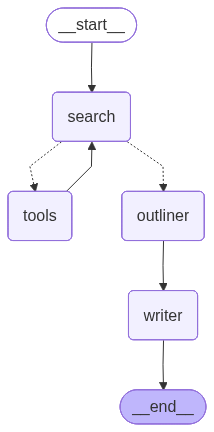

In [ ]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### Test it out!

In [18]:
from langchain_core.messages import HumanMessage

input_message = HumanMessage(content="latest trends on AI")

for event in graph.stream({"messages": [input_message]}, stream_mode="values"):
  event['messages'][-1].pretty_print()

================================ Human Message =================================

latest trends on AI
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (823adbbd-bb90-44f0-b560-5143b160b0b2)
 Call ID: 823adbbd-bb90-44f0-b560-5143b160b0b2
  Args:
    query: latest trends on AI
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Five Trends in AI and Data Science for 2026", "url": "https://sloanreview.mit.edu/article/five-trends-in-ai-and-data-science-for-2026/", "content": "Companies that are all in on AI as an ongoing competitive advantage are putting infrastructure in place to speed up the pace of AI models and use-case development. We’re not talking about building big data centers with tens of thousands of GPUs; that’s generally being done by vendors. But companies that use rather than sell AI are creating “AI factories”: combinations of t